Estimated E_p[x]: 0.8857
Estimated Var_p[x]: 0.1012
True E_p[x] (from direct samples): -0.0219
True Var_p[x] (from direct samples): 0.9003
Effective Sample Size (ESS): 909.01


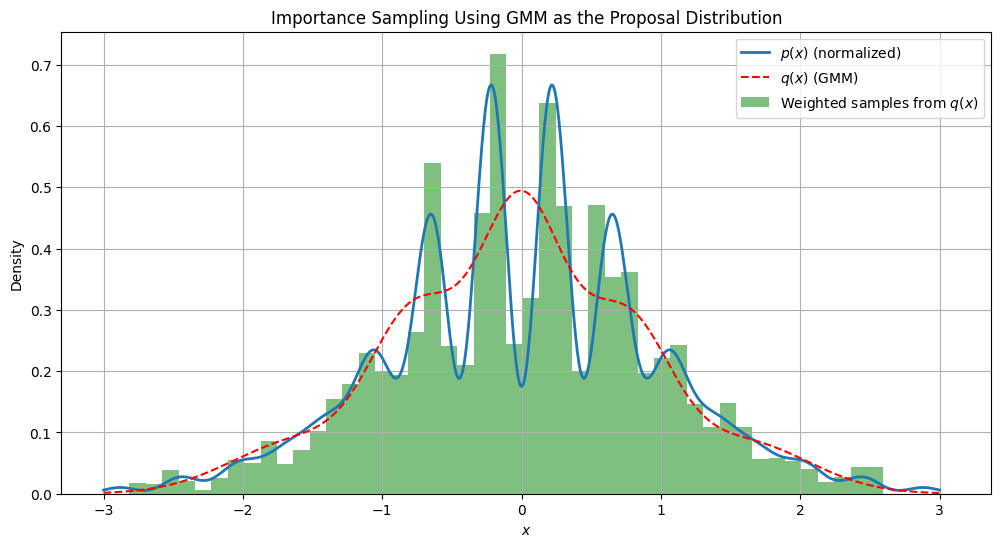

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture


def p(x):
    """
    Compute the unnormalized target density function p(x).
    """
    exp_component = np.exp(-0.5 * x**2)
    sinusoidal_component = np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    px = exp_component * sinusoidal_component
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


In [ ]:
# Step 1: Prepare data and fit the GMM to approximate p(x)

# Generate a fine grid within [-3, 3]
x_grid = np.linspace(-3, 3, 1000)
px_values = p(x_grid)

# Normalize p(x) to create a proper probability density function
dx = x_grid[1] - x_grid[0]
area_under_px = np.sum(px_values) * dx
px_normalized = px_values / area_under_px

# Inverse transform sampling to generate samples from p(x)
# Compute the cumulative distribution function (CDF)
cdf_px = np.cumsum(px_normalized) * dx
cdf_px = cdf_px / cdf_px[-1]  # Normalize to [0,1]

# Create an interpolator for the inverse CDF
inverse_cdf_px = interp1d(
    cdf_px, x_grid, bounds_error=False, fill_value=(x_grid[0], x_grid[-1])
)

# Generate random samples from p(x)
np.random.seed(42)
num_samples_p = 10000
uniform_random_numbers = np.random.rand(num_samples_p)
samples_p = inverse_cdf_px(uniform_random_numbers)

# Fit a Gaussian Mixture Model to the samples from p(x)
n_components = 5  # Adjust the number of components as needed
gmm = GaussianMixture(
    n_components=n_components, covariance_type="full", random_state=42
)
gmm.fit(samples_p.reshape(-1, 1))


In [ ]:
# Step 2: Use the GMM as the proposal distribution q(x) to generate samples
num_samples_q = 1000
samples_q, _ = gmm.sample(num_samples_q)
samples_q = samples_q.flatten()

# Step 3: Compute importance weights w(x) = p(x) / q(x)
# Evaluate p(x) at the sampled points
px_at_samples_q = p(samples_q)

# Evaluate q(x) using the GMM's PDF
log_qx = gmm.score_samples(samples_q.reshape(-1, 1))
qx_at_samples_q = np.exp(log_qx)

# Compute importance weights
weights = px_at_samples_q / qx_at_samples_q

# Handle potential numerical issues (e.g., division by zero)
epsilon = 1e-10
valid_indices = qx_at_samples_q > epsilon
samples_q = samples_q[valid_indices]
weights = weights[valid_indices]

weights /= np.sum(weights)  # Normalize the weights

px_at_samples_q = px_at_samples_q[valid_indices]
qx_at_samples_q = qx_at_samples_q[valid_indices]


In [ ]:
# Step 4: Estimate the expectation E_p[f(x)] using importance sampling
# Example: Estimate the mean E_p[x] and variance E_p[(x - E_p[x])^2]

# Estimate E_p[x]
f_x = samples_q  # f(x) = x
estimated_mean = np.sum(weights * f_x**2)

# Estimate E_p[x^2]
f_x2 = samples_q**2  # f(x) = x^2
estimated_mean_square = np.sum(weights * f_x2) / np.sum(weights)

# Compute the estimated variance Var_p[x] = E_p[x^2] - (E_p[x])^2
estimated_variance = estimated_mean_square - estimated_mean**2

print(f"Estimated E_p[x]: {estimated_mean:.4f}")
print(f"Estimated Var_p[x]: {estimated_variance:.4f}")

# For comparison, compute the true mean and variance using samples from p(x)
true_mean = np.mean(samples_p)
true_variance = np.var(samples_p)
print(f"True E_p[x] (from direct samples): {true_mean:.4f}")
print(f"True Var_p[x] (from direct samples): {true_variance:.4f}")

# Compute Effective Sample Size (ESS)
ess = (np.sum(weights)) ** 2 / np.sum(weights**2)
print(f"Effective Sample Size (ESS): {ess:.2f}")

# Plot the results
# Plot the normalized p(x)
plt.figure(figsize=(12, 6))
plt.plot(x_grid, px_normalized, label="$p(x)$ (normalized)", linewidth=2)

# Plot the GMM approximation q(x)
x_gmm = np.linspace(-3, 3, 1000)
logprob_q = gmm.score_samples(x_gmm.reshape(-1, 1))
qx_values = np.exp(logprob_q)
plt.plot(x_gmm, qx_values, label="$q(x)$ (GMM)", linestyle="--", color="red")

# Plot histogram of samples from q(x) weighted by the importance weights
plt.hist(
    samples_q,
    bins=50,
    density=True,
    weights=weights,
    alpha=0.5,
    color="green",
    label="Weighted samples from $q(x)$",
)

# Customize the plot
plt.title("Importance Sampling Using GMM as the Proposal Distribution")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()